In [1]:
from utils import *

from os import listdir
from os.path import isfile, join

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(49)

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [5]:
dataset_ex_df = pd.read_csv('TSLA.csv', header=0, parse_dates=[0], date_parser=parser)

In [6]:
dataset_ex_df.head()

,Date,TSLA
0,2010-06-30,4.766
1,2010-07-01,4.392
2,2010-07-02,3.840
3,2010-07-06,3.222
4,2010-07-07,3.160


In [7]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2393 number of days in the dataset.


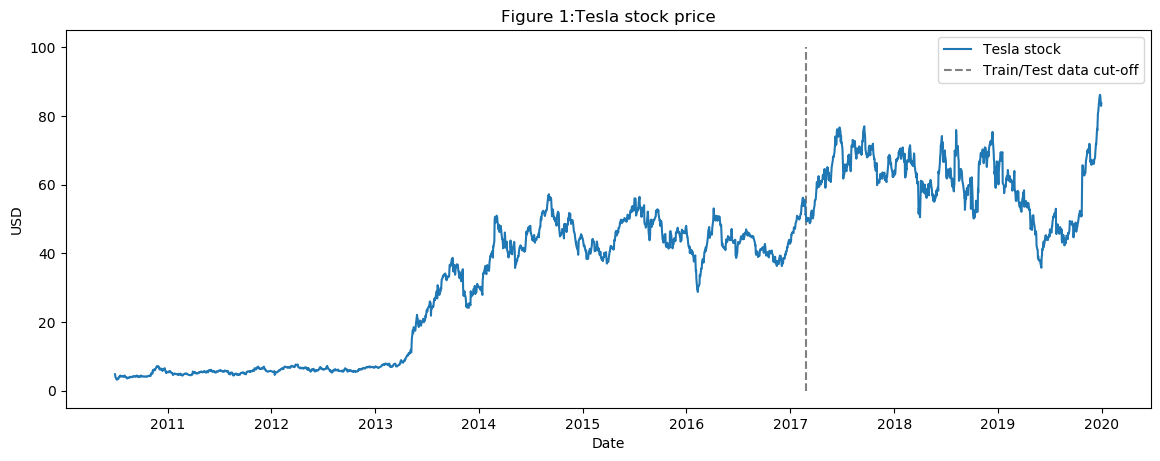

In [8]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['TSLA'], label='Tesla stock')
plt.vlines(datetime.date(2017,2, 24), 0, 100, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1:Tesla stock price')
plt.legend()
plt.show()

In [9]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1675. Number of test days: 718.


In [10]:
#adding features
for i in ['bonds', 'commodities', 'currencies', 'indices', 'libor', 'stocks']:
    mypath = 'correlated_assets/' + str(i)
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for j in onlyfiles:
        dataset_tmpr = pd.read_csv('correlated_assets/'+str(i)+'/'+str(j), header=0, parse_dates=[0], date_parser=parser)
        dataset_tmpr = dataset_tmpr[(dataset_tmpr['Date'] > '2010-06-29') & (dataset_tmpr['Date'] < '2020-01-01')]
        dataset_tmpr = dataset_tmpr.drop(['Open', 'High', 'Low'], axis = 1).reset_index(drop = True)
        dataset_tmpr.columns = ['Date', j[:-4]]
        dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    

In [11]:
dataset_ex_df = dataset_ex_df.fillna(method = 'ffill')
#last resort
dataset_ex_df = dataset_ex_df.fillna(method = 'bfill')

In [18]:
dataset_ex_df.head()

,Date,TSLA,10usy_b_d,30usy_b_d,cb_f_d,cl_f_d,gc_f_d,rb_f_d,usdchf_d,usdeur_d,...,F,FCAU,GM,HMC,HYMTF,NSANY,PUGOY,RNOPA,TM,VOW3DE
0,2010-06-30,4.766,2.951,3.909,74.69,75.24,1242.6,2.0600,1.0777,0.8175,...,10.08,3.226447,34.189999,28.750000,21.250000,13.86,25.65,30.785000,68.570000,72.379997
1,2010-07-01,4.392,2.927,3.868,72.19,72.68,1199.8,1.9910,1.0596,0.7988,...,10.57,3.226447,34.189999,28.799999,19.799999,13.72,25.34,29.559999,68.699997,69.970001
2,2010-07-02,3.840,2.979,3.941,71.63,72.14,1207.7,1.9777,1.0622,0.7959,...,10.28,3.226447,34.189999,28.590000,19.799999,13.76,26.10,30.170000,68.260002,70.070000
3,2010-07-06,3.222,2.932,3.892,71.77,72.02,1194.0,1.9775,1.0595,0.7921,...,10.16,3.226447,34.189999,29.190001,19.799999,14.62,26.10,31.125000,70.029999,71.379997
4,2010-07-07,3.160,2.980,3.954,74.46,74.85,1202.5,2.0425,1.0522,0.7918,...,10.59,3.226447,34.189999,29.459999,19.400000,14.62,28.15,32.145000,71.000000,71.239998


In [30]:
#adding technical indicators
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['TSLA'].rolling(window=7).mean()
    dataset['ma21'] = dataset['TSLA'].rolling(window=21).mean()
    
    #Create MACD
    dataset['26ema'] = pd.Series.ewm(dataset['TSLA'], span=26).mean()
    dataset['12ema'] = pd.Series.ewm(dataset['TSLA'], span=12).mean()
    
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    # Create Bollinger Bands
    dataset['20sd'] = dataset['TSLA'].rolling(window = 20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['TSLA'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['TSLA']-1
    
    return dataset

In [31]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['TSLA']])

In [33]:
dataset_TI_df.head()

,TSLA,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,4.766,NaN,NaN,4.766000,4.766000,0.000000,NaN,NaN,NaN,4.766000,3.766
1,4.392,NaN,NaN,4.571808,4.563417,-0.008391,NaN,NaN,NaN,4.485500,3.392
2,3.840,NaN,NaN,4.308876,4.281067,-0.027809,NaN,NaN,NaN,4.038615,2.840
3,3.222,NaN,NaN,4.005033,3.946761,-0.058272,NaN,NaN,NaN,3.487400,2.222
4,3.160,NaN,NaN,3.809066,3.733001,-0.076066,NaN,NaN,NaN,3.268231,2.160


In [44]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['TSLA'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.15)
    plt.title('Technical indicators for Tesla - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

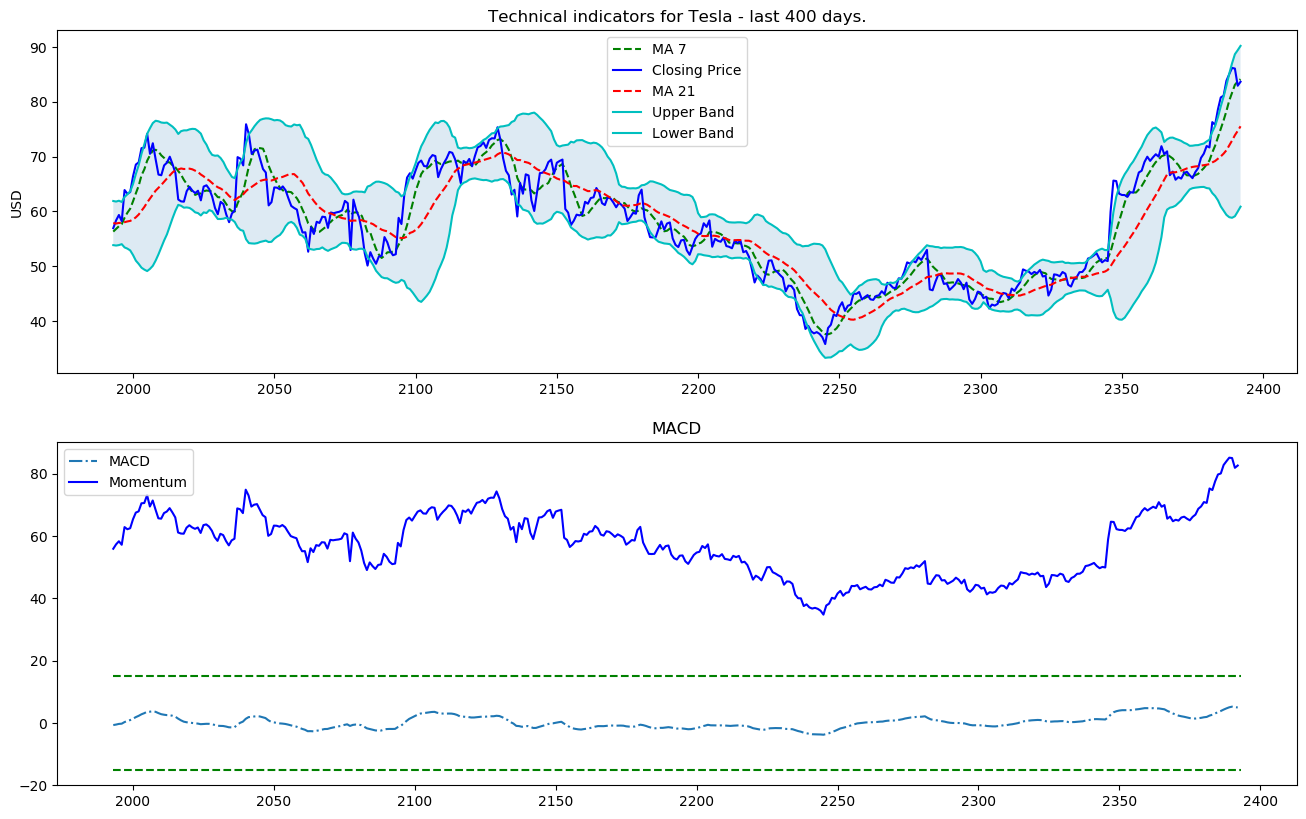

In [45]:
plot_technical_indicators(dataset_TI_df, 400)